In [3]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product
import torch.nn.functional as F

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'

In [4]:
from utils import *
from embed import *

models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [4]:
T = 45000
ts = []
for t in range(T):
    if t < T//10:
        if t % (T//100) == 0:
            ts.append(t)
    else:
        if t % (T//10) == 0 or (t == T-1):
            ts.append(t)
ts = np.array(ts)
tmap = {i:ts[i] for i in range(len(ts))}
pts = np.concatenate([np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])
N = len(pts)

## Bhat vs InPCA

In [ ]:
loc = 'inpca_results'
fn = 'yh_new_interpolate_with_avg'
L = th.load(os.path.join(loc,'w_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

In [ ]:
P = np.eye(L.shape[0]) - 1.0/L.shape[0]
W = -P @ L @ P / 2 
n = len(W)
r = proj_(W, n, 500)

Projecting


In [ ]:
df = pd.DataFrame(np.vstack([np.abs(r['e']), np.sign(r['e'])]).T, columns=['value', 'sign'])

In [ ]:
# plt.plot(df['value'])
ax = sns.scatterplot(data=df, x=df.index, y='value', hue='sign')
ax.set_yscale('log')

In [ ]:
from distance import dbhat, dinpca

dists = []
k = 'yh'
m = models[0]
o = opts[0]
seeds = dc['seed'].unique()
L = th.Tensor(L)
l = th.norm(L).item()
avg_fnorm = []
for ne in np.concatenate([np.arange(10, 50, 10), np.arange(50, 200, 50), np.arange(200, 1000, 300)]):
    print(ne)
    if ne > 100:
        di = th.zeros_like(L)
        for k in range(ne // 100+1):
            xi = th.Tensor(r['xp'][:, k*100:min((k+1)*100, ne)])
            sgn = th.Tensor(np.sign(r['e'][k*100:min((k+1)*100, ne)]))
            di += dinpca(xi, xi, sgn, dev='cpu')
    else:
        di = dinpca(th.Tensor(r['xp'][:, :ne]), th.Tensor(r['xp'][:, :ne]), th.Tensor(np.sign(r['e'][:ne])), dev='cpu')
    avg_fnorm.append(dict(fnorm=th.norm(di.cpu()-L).item() / l, ne=ne))
dists = pd.DataFrame(dists)

<AxesSubplot:xlabel='ne', ylabel='fnorm'>

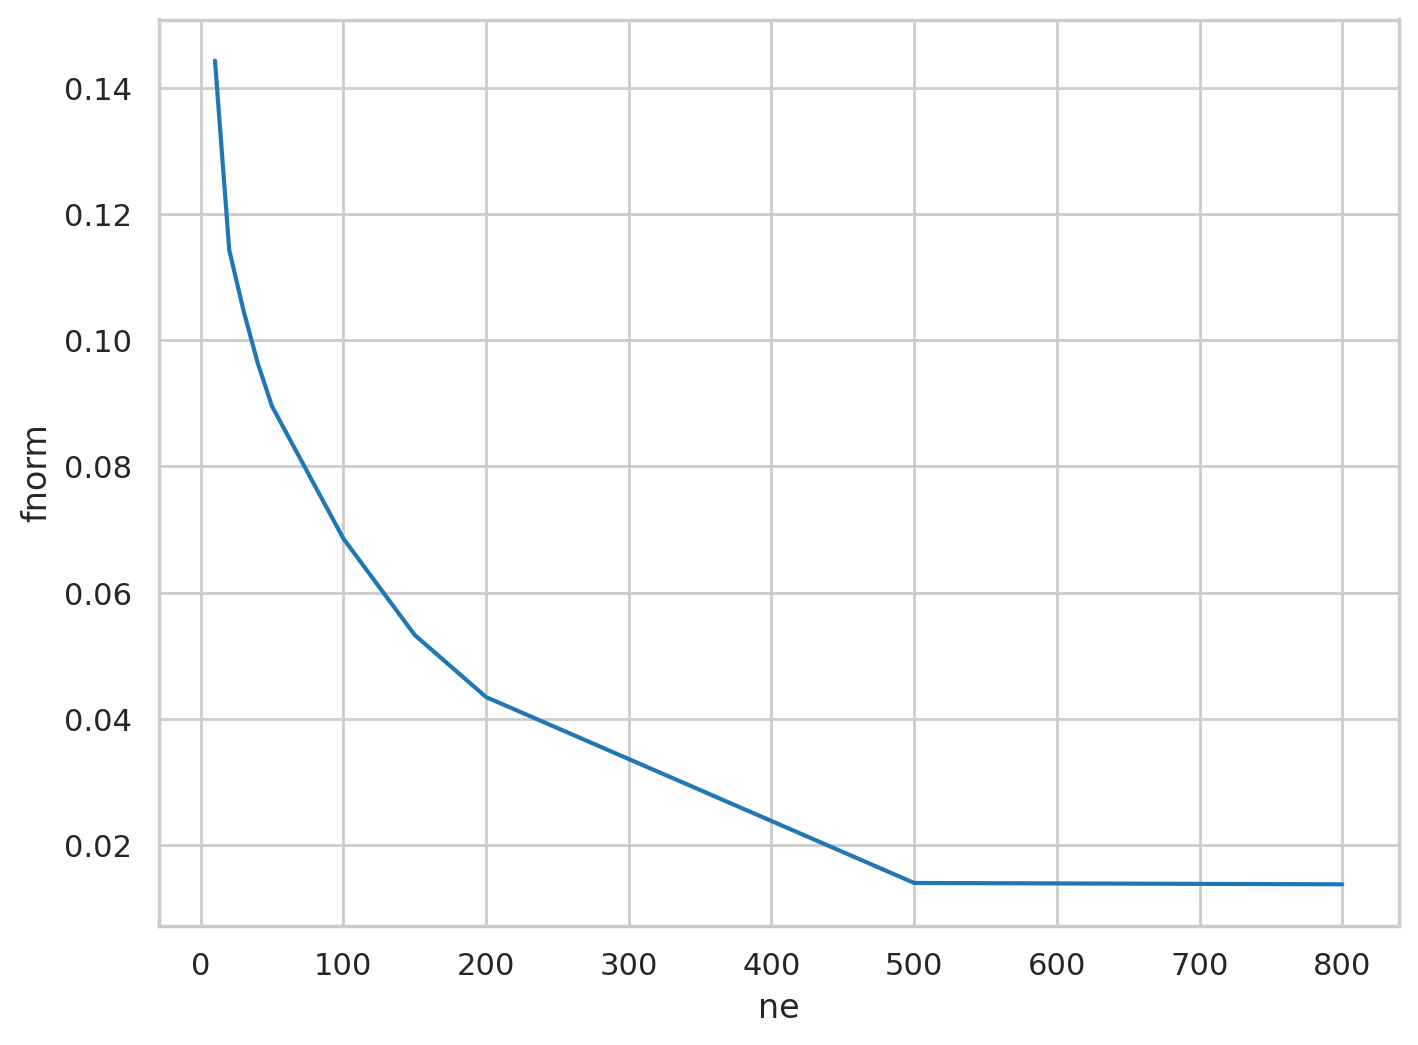

In [ ]:
df = pd.DataFrame(avg_fnorm)
sns.lineplot(data=df, x='ne', y='fnorm')

## Distance to avg

In [5]:
from distance import *

In [6]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs': [200], 'aug': [True], 'wd': [0.0], 'bn': [True], 'm': models, 'opt': opts},
           avg_err=True, drop=True, probs=True)

avgd = avg_model(d, groupby=['m', 'opt', 't'], probs=True, get_err=True,
              update_d=True, compute_distance=False, dev='cuda')['d']
interpd = interpolate(avgd, ts, pts, columns=['seed', 'm', 'opt', 'avg'], keys=['yh'], dev='cuda')

Index(['index', 'seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh',
       'f', 'e', 'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


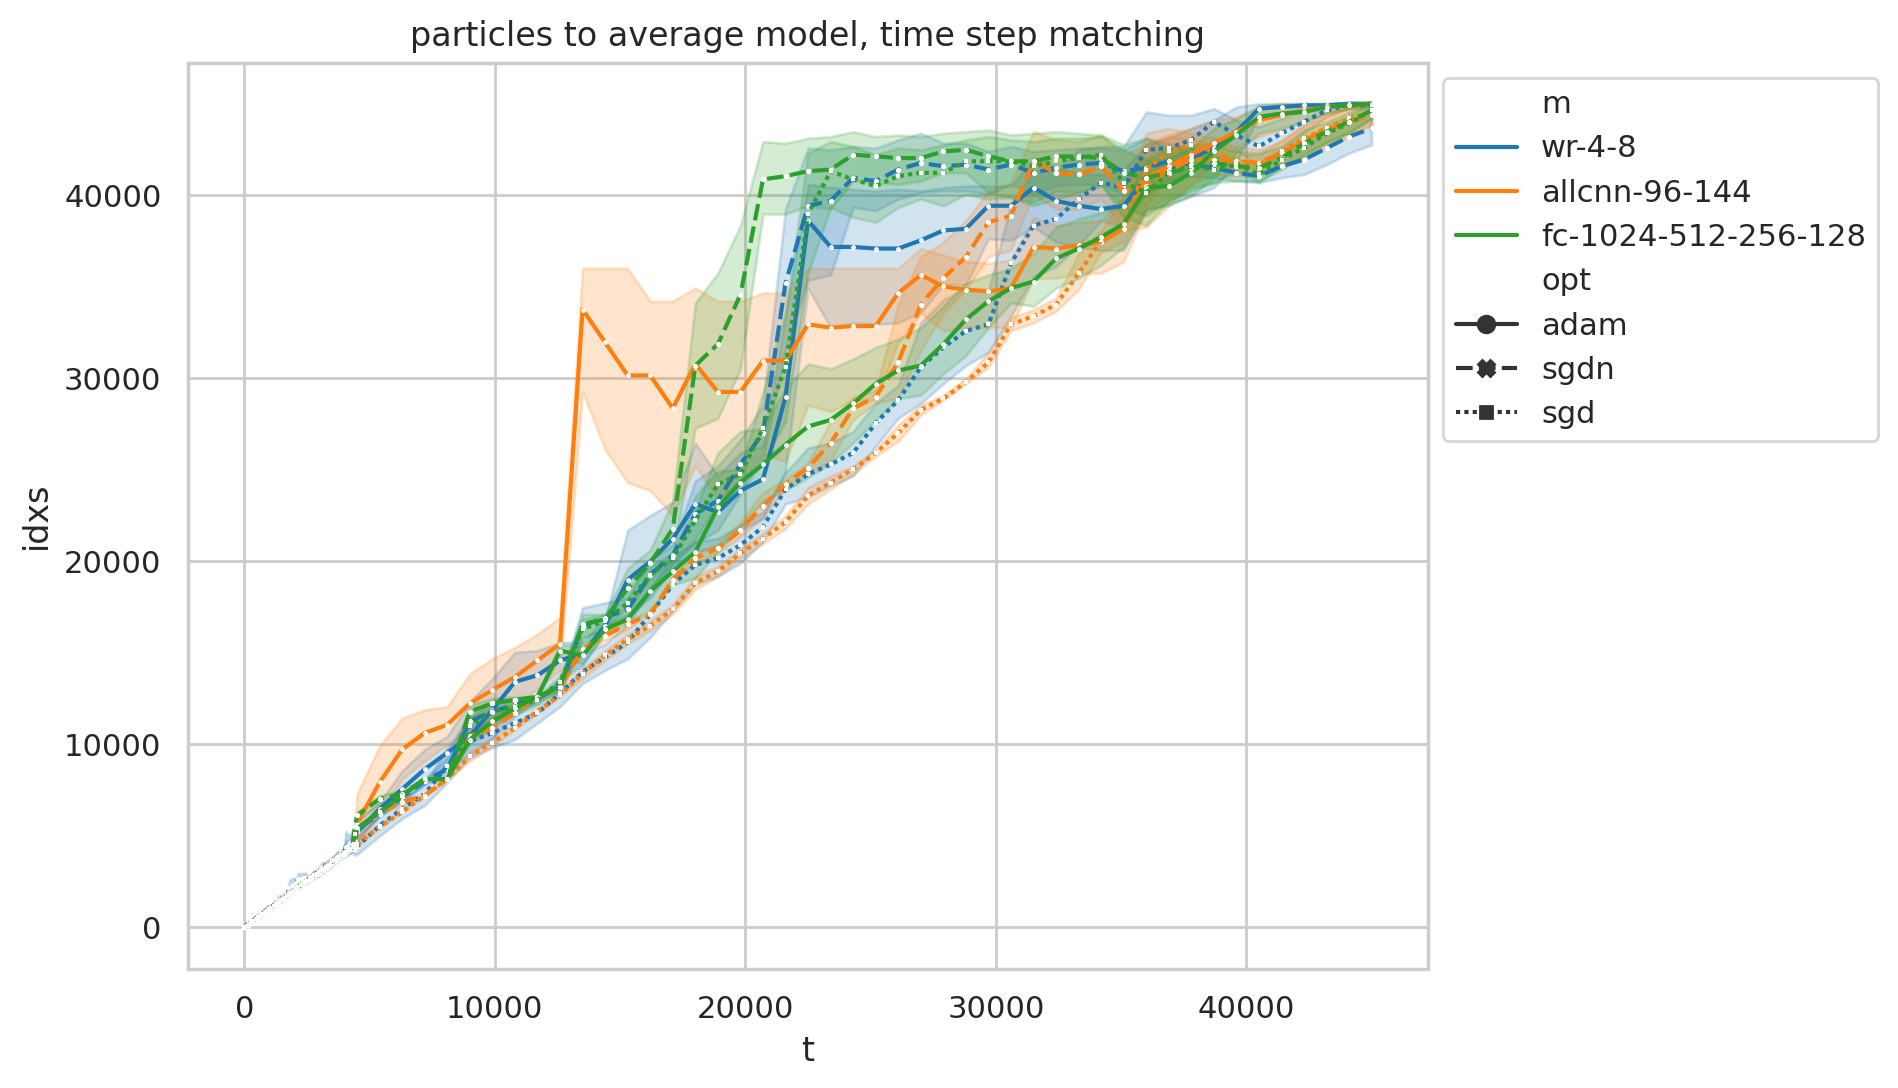

In [7]:
dists = []
k = 'yh'
d = interpd 
tidxs = pts
for o in opts:
    for m in models:
        i1 = get_idx(d, f"m=='{m}' & opt=='{o}'& avg==True")
        for seed in d['seed'].unique():
            if seed < 0:
                continue
            i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & seed=={seed}")
            kdist, idxs = dp2t(th.Tensor(np.stack(d.iloc[i2][k].values)), 
                            th.Tensor(np.stack(d.iloc[i1][k].values)), s=0.0, return_idxs=True)
            for i in range(len(kdist)):
                dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                    t=tidxs[i], key=k, seed=seed, idxs=tidxs[idxs[i].item()]))
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists, x='t', y='idxs', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('particles to average model, time step matching')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

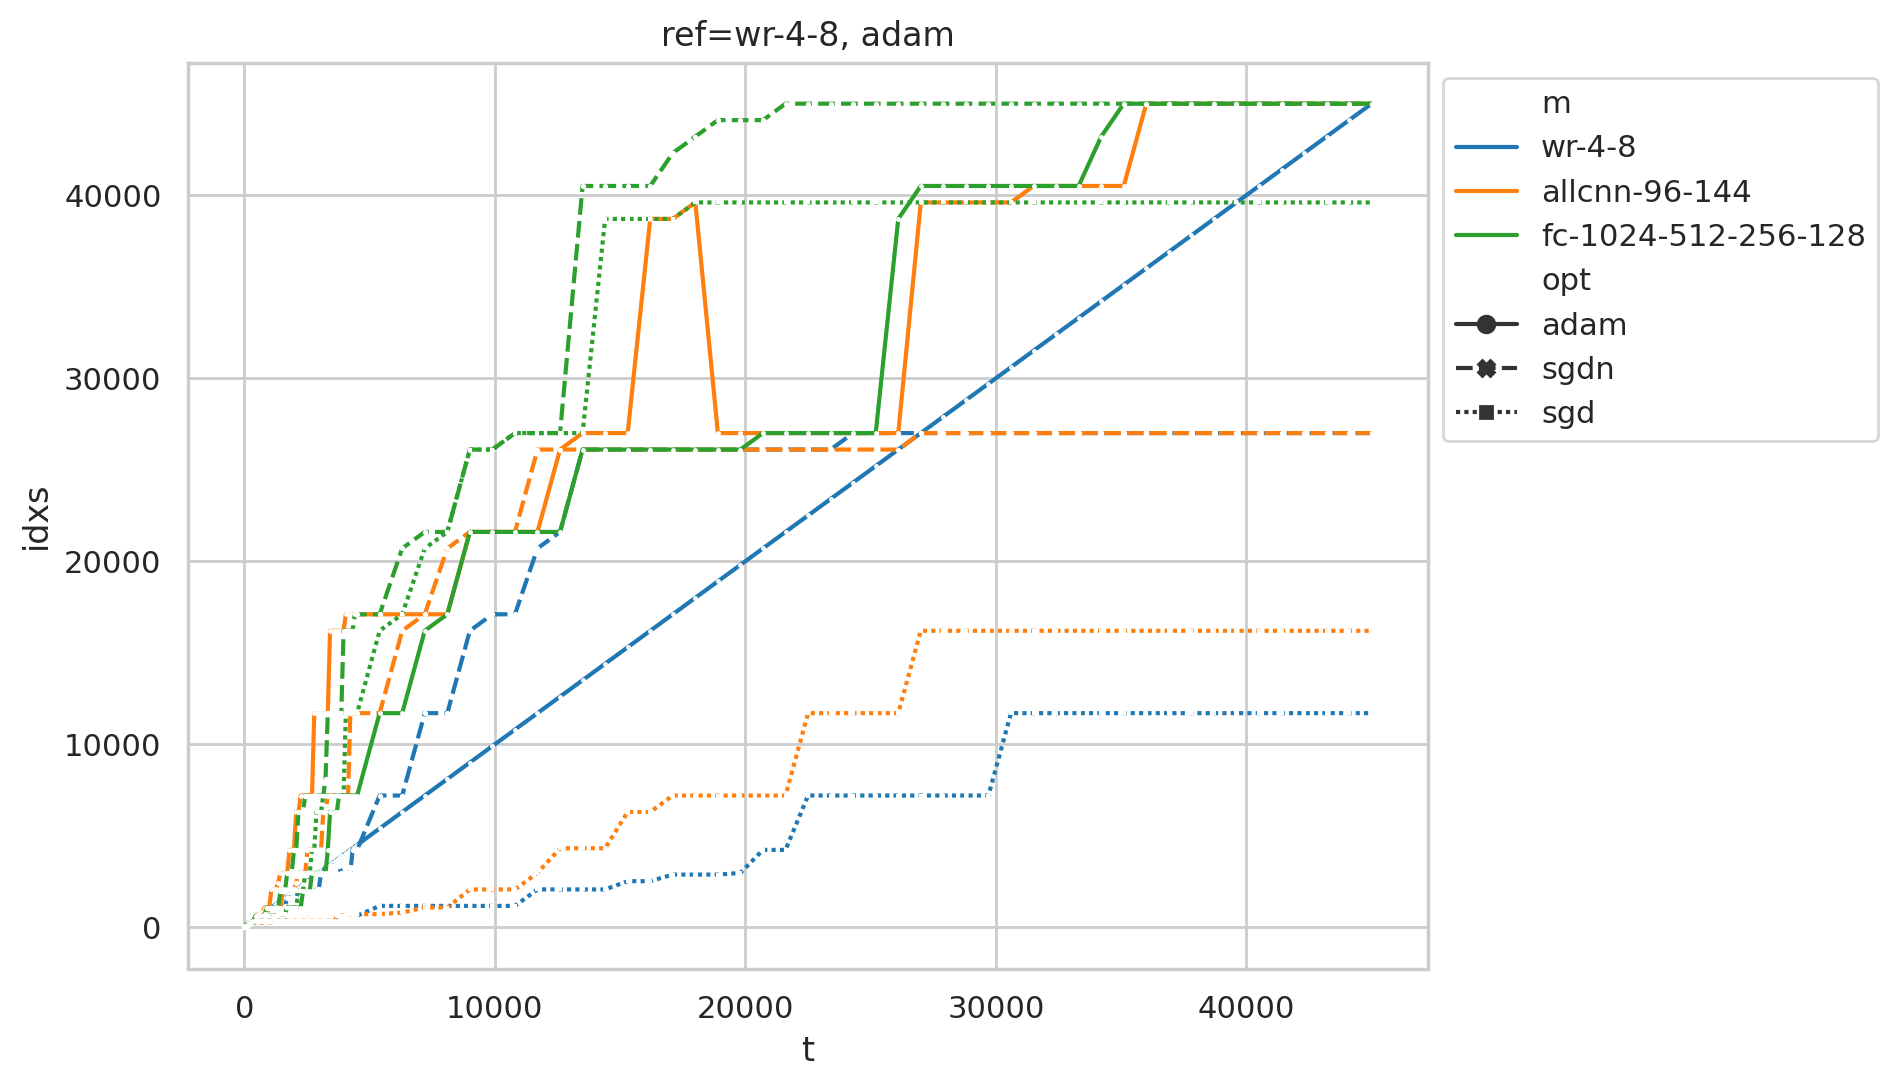

In [11]:
dists = []
k = 'yh'
ref= get_idx(d, f"m=='{models[0]}' & opt=='{opts[0]}'& avg==True")
d = interpd
tidxs = pts
for o in opts:
    for m in models:
        i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & avg==True")
        kdist, idxs = dp2t(th.Tensor(np.stack(d.iloc[i2][k].values)), 
                        th.Tensor(np.stack(d.iloc[ref][k].values)), s=0.0, return_idxs=True)
        for i in range(len(kdist)):
            dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                t=tidxs[i], key=k, seed=seed, idxs=tidxs[idxs[i].item()]))
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists, x='t', y='idxs', hue='m', style='opt', markers=True, markersize=1)
ax.set_title(f'dist to avgm, ref={models[0]}, {opts[0]}')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

## Pairwise Distance

In [51]:
def plot_pairwise_dist(dists, configs, 
                    cconds=[lambda x: True], 
                    rconds=[lambda x: True], 
                    sortby=1, mean=False, annot=False,
                    xblock_size=10, yblock_size=1, 
                    label_idxs=slice(0,-1),
                    square=False, return_didx=False):
    cidxs = []
    ridxs = []
    columns = []
    rows = []
    if square:
        rconds = cconds
        yblock_size = xblock_size
    if cconds or rconds:
        for (i, c) in enumerate(configs):
            if cconds and all(f(c) for f in cconds):
                cidxs.append(i)
                columns.append(c)
            if rconds and all(f(c) for f in rconds):
                ridxs.append(i)
                rows.append(c)
    else:
        cidxs, ridxs = range(len(configs)), range(len(configs))
        columns, rows = configs, configs
    cidxs, ridxs = np.array(cidxs), np.array(ridxs)
    columns, rows = np.stack(columns), np.stack(rows)
    cidxs = cidxs[np.lexsort(columns[:, sortby:sortby+1].T)]
    columns = columns[np.lexsort(columns[:, sortby:sortby+1].T), label_idxs]
    ridxs = ridxs[np.lexsort(rows[:, sortby:sortby+1].T)]
    rows = rows[np.lexsort(rows[:, sortby:sortby+1].T), label_idxs]
    didxs=dists[:, cidxs][ridxs]
    if mean:
        didxs = F.conv2d(th.Tensor(didxs).unsqueeze(0).unsqueeze(0), 
                         weight=th.ones(1,1, yblock_size, xblock_size)/(xblock_size*yblock_size), stride=(yblock_size, xblock_size)).squeeze().numpy()
        columns = columns[::xblock_size]
        rows = rows[::yblock_size]
    if return_didx:
        return didxs, rows, columns
    
    if mean:
        ax = sns.heatmap(pd.DataFrame(didxs, columns=columns, index=rows), annot=annot, fmt='.2g')
    else:
        ax = sns.heatmap(pd.DataFrame(didxs, columns=columns, index=rows), 
                    xticklabels=xblock_size, yticklabels=yblock_size, annot=annot, fmt='.2g')
    return ax, didxs, rows, columns

Text(0.5, 1.0, 'bootstrap_avg_no_interp')

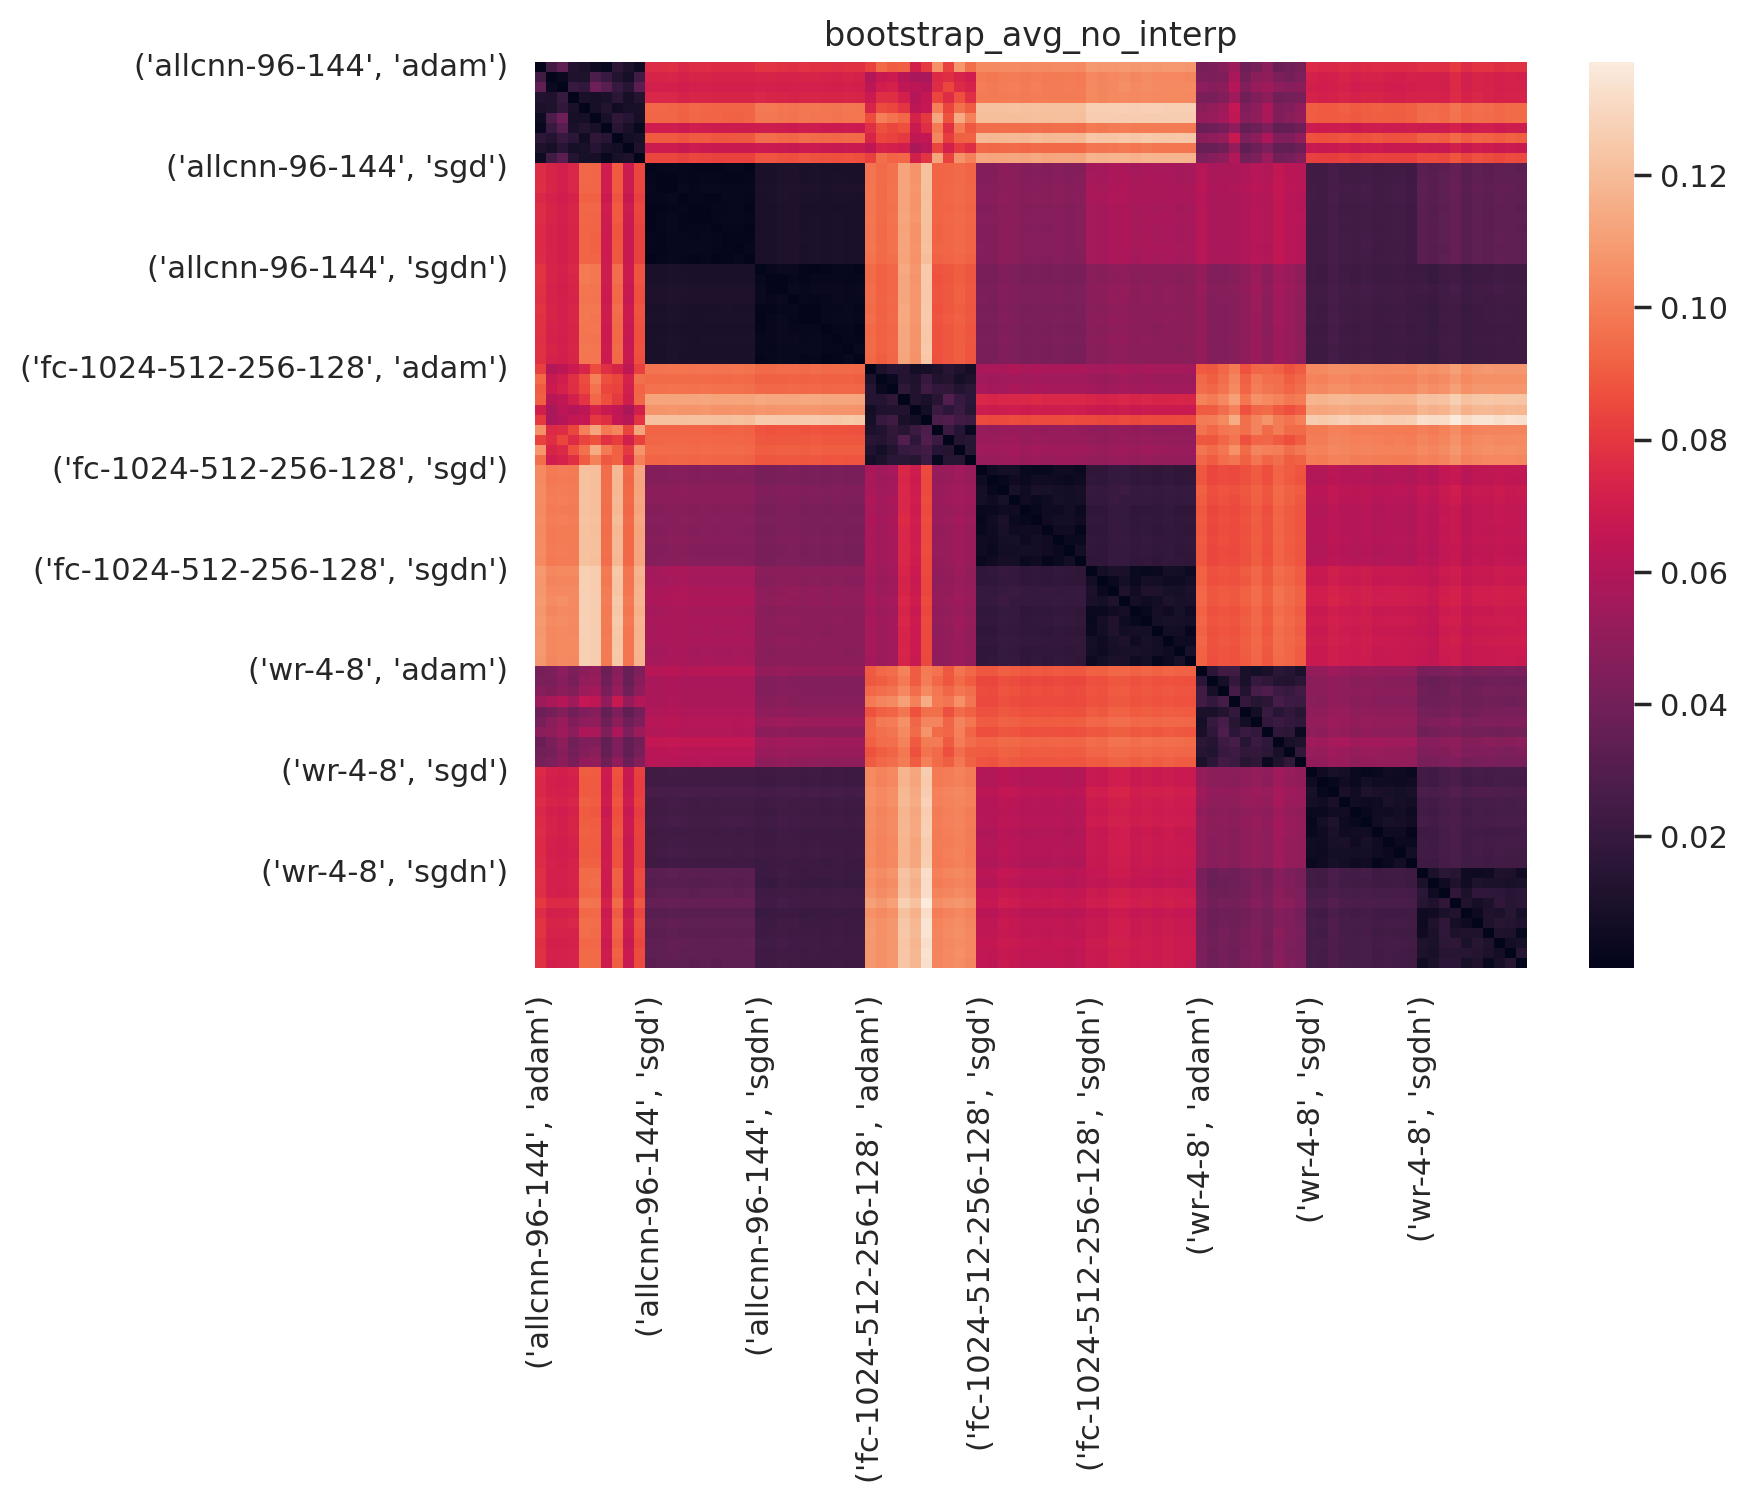

In [249]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length_bootstrap'
dists, symd, configs, groups = th.load(
    os.path.join(loc, f'{fname}.p')).values()
ax, didxs, rows, columns = plot_pairwise_dist(symd, configs, 
    cconds=[lambda x: len(x[-1]) > 2],
    # rconds=[lambda x: x[1]=='wr-4-8', lambda x: x[2]=='sgd', lambda x: len(x[-1]) > 2],
    sortby=1, xblock_size=10, yblock_size=10, square=True, label_idxs=slice(1,3),
    mean=False,annot=False)
ax.set_title('bootstrap_avg_no_interp')

Text(0.5, 1.0, 'bootstrap_avg_interp')

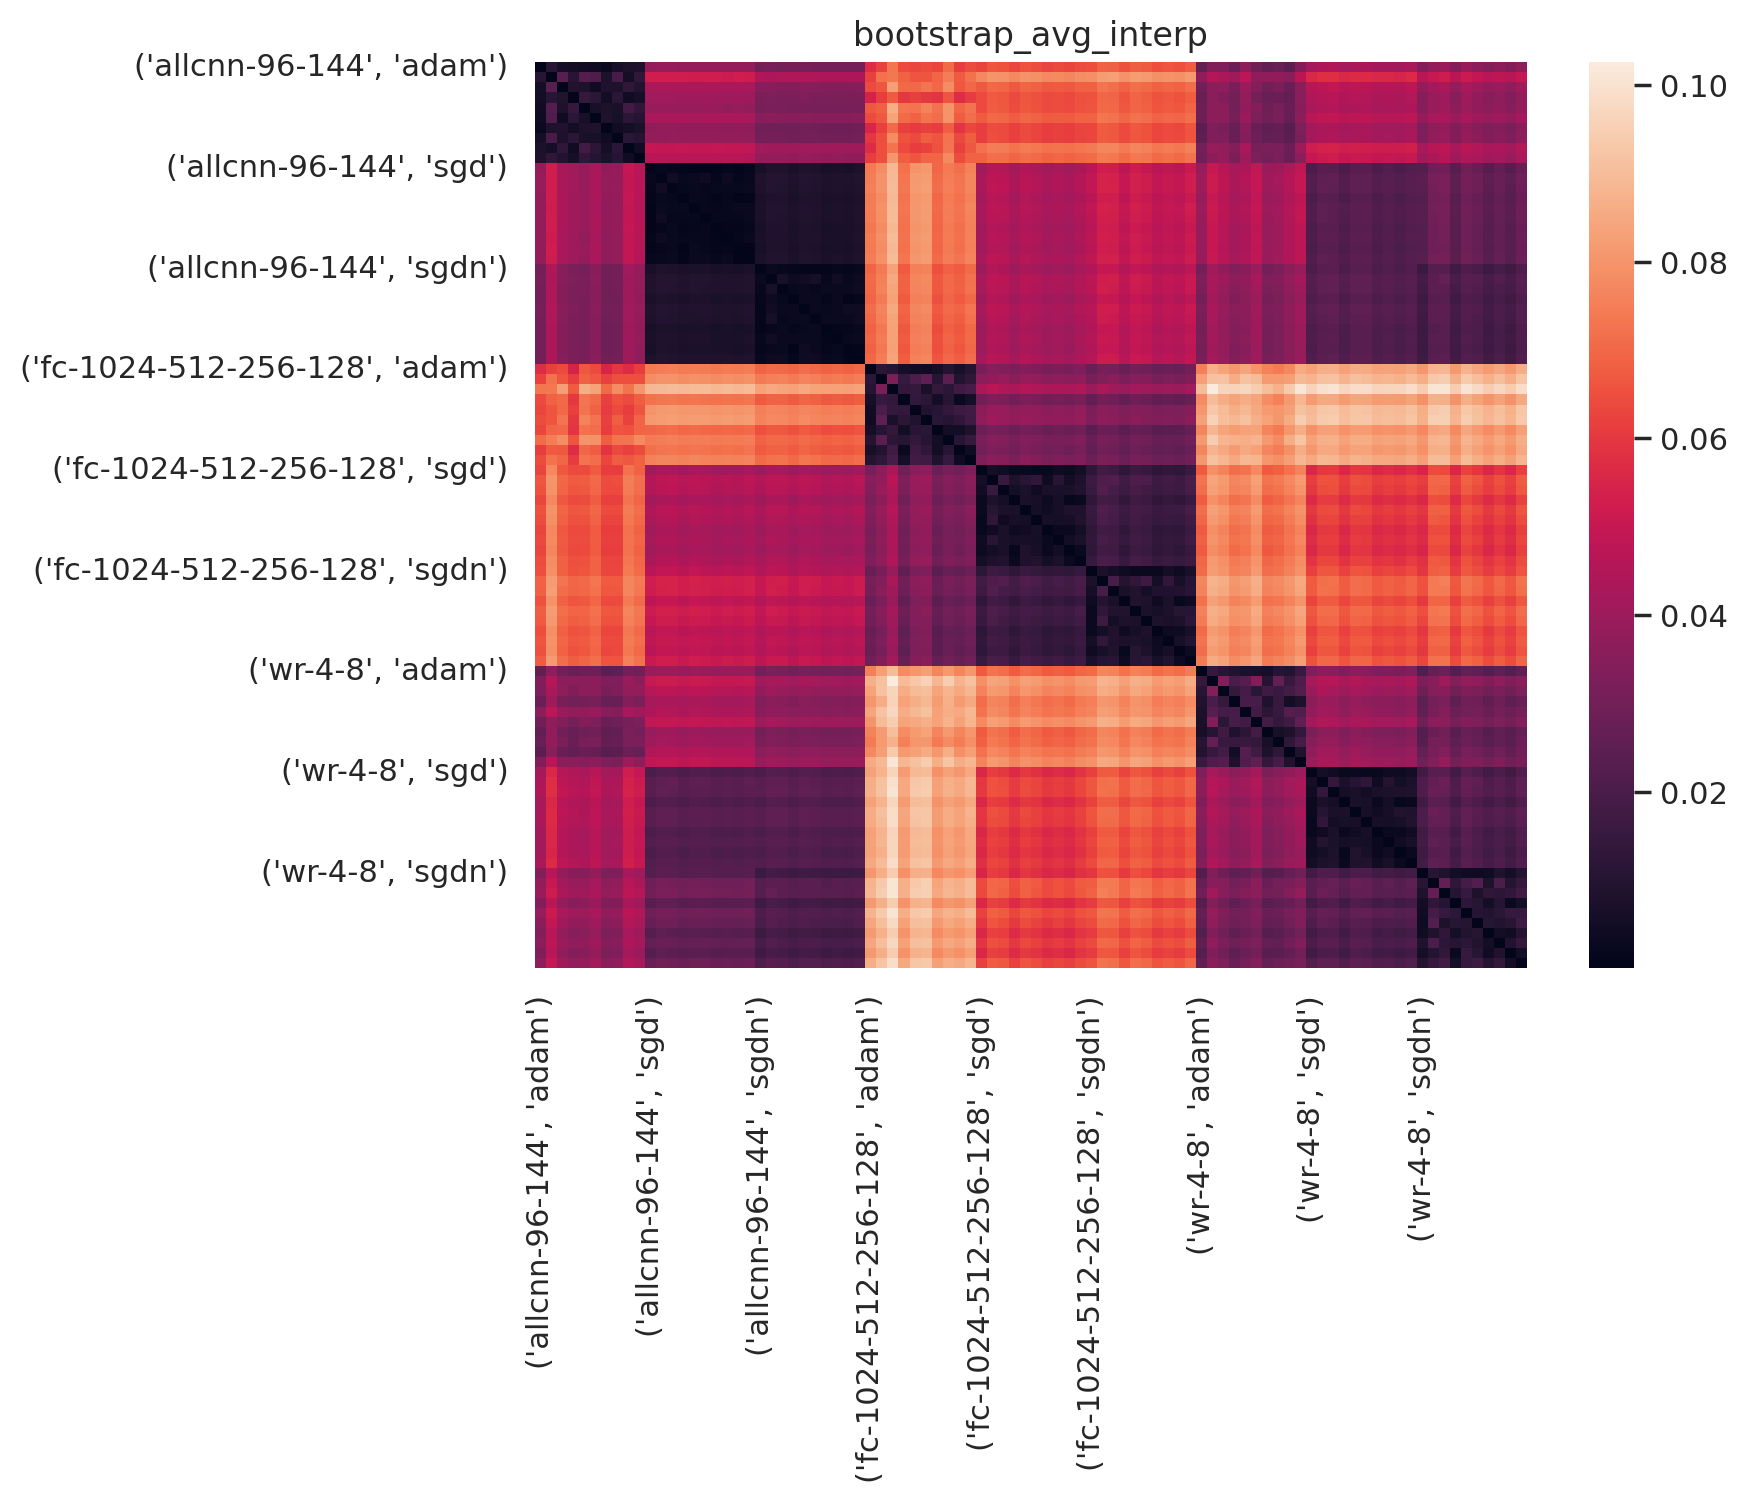

In [11]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length_bootstrap_interpolate'
dists, symd, configs, groups = th.load(
    os.path.join(loc, f'{fname}.p')).values()
ax, didxs, rows, columns = plot_pairwise_dist(symd, configs, 
    cconds=[lambda x: len(x[-1]) > 2],
    # rconds=[lambda x: x[1]=='wr-4-8', lambda x: x[2]=='sgd', lambda x: len(x[-1]) > 2],
    sortby=1, xblock_size=10, yblock_size=10, square=True, label_idxs=slice(1,3),
    mean=False,annot=False)
ax.set_title('bootstrap_avg_interp')

Text(0.5, 1.0, 'avgm_pdist')

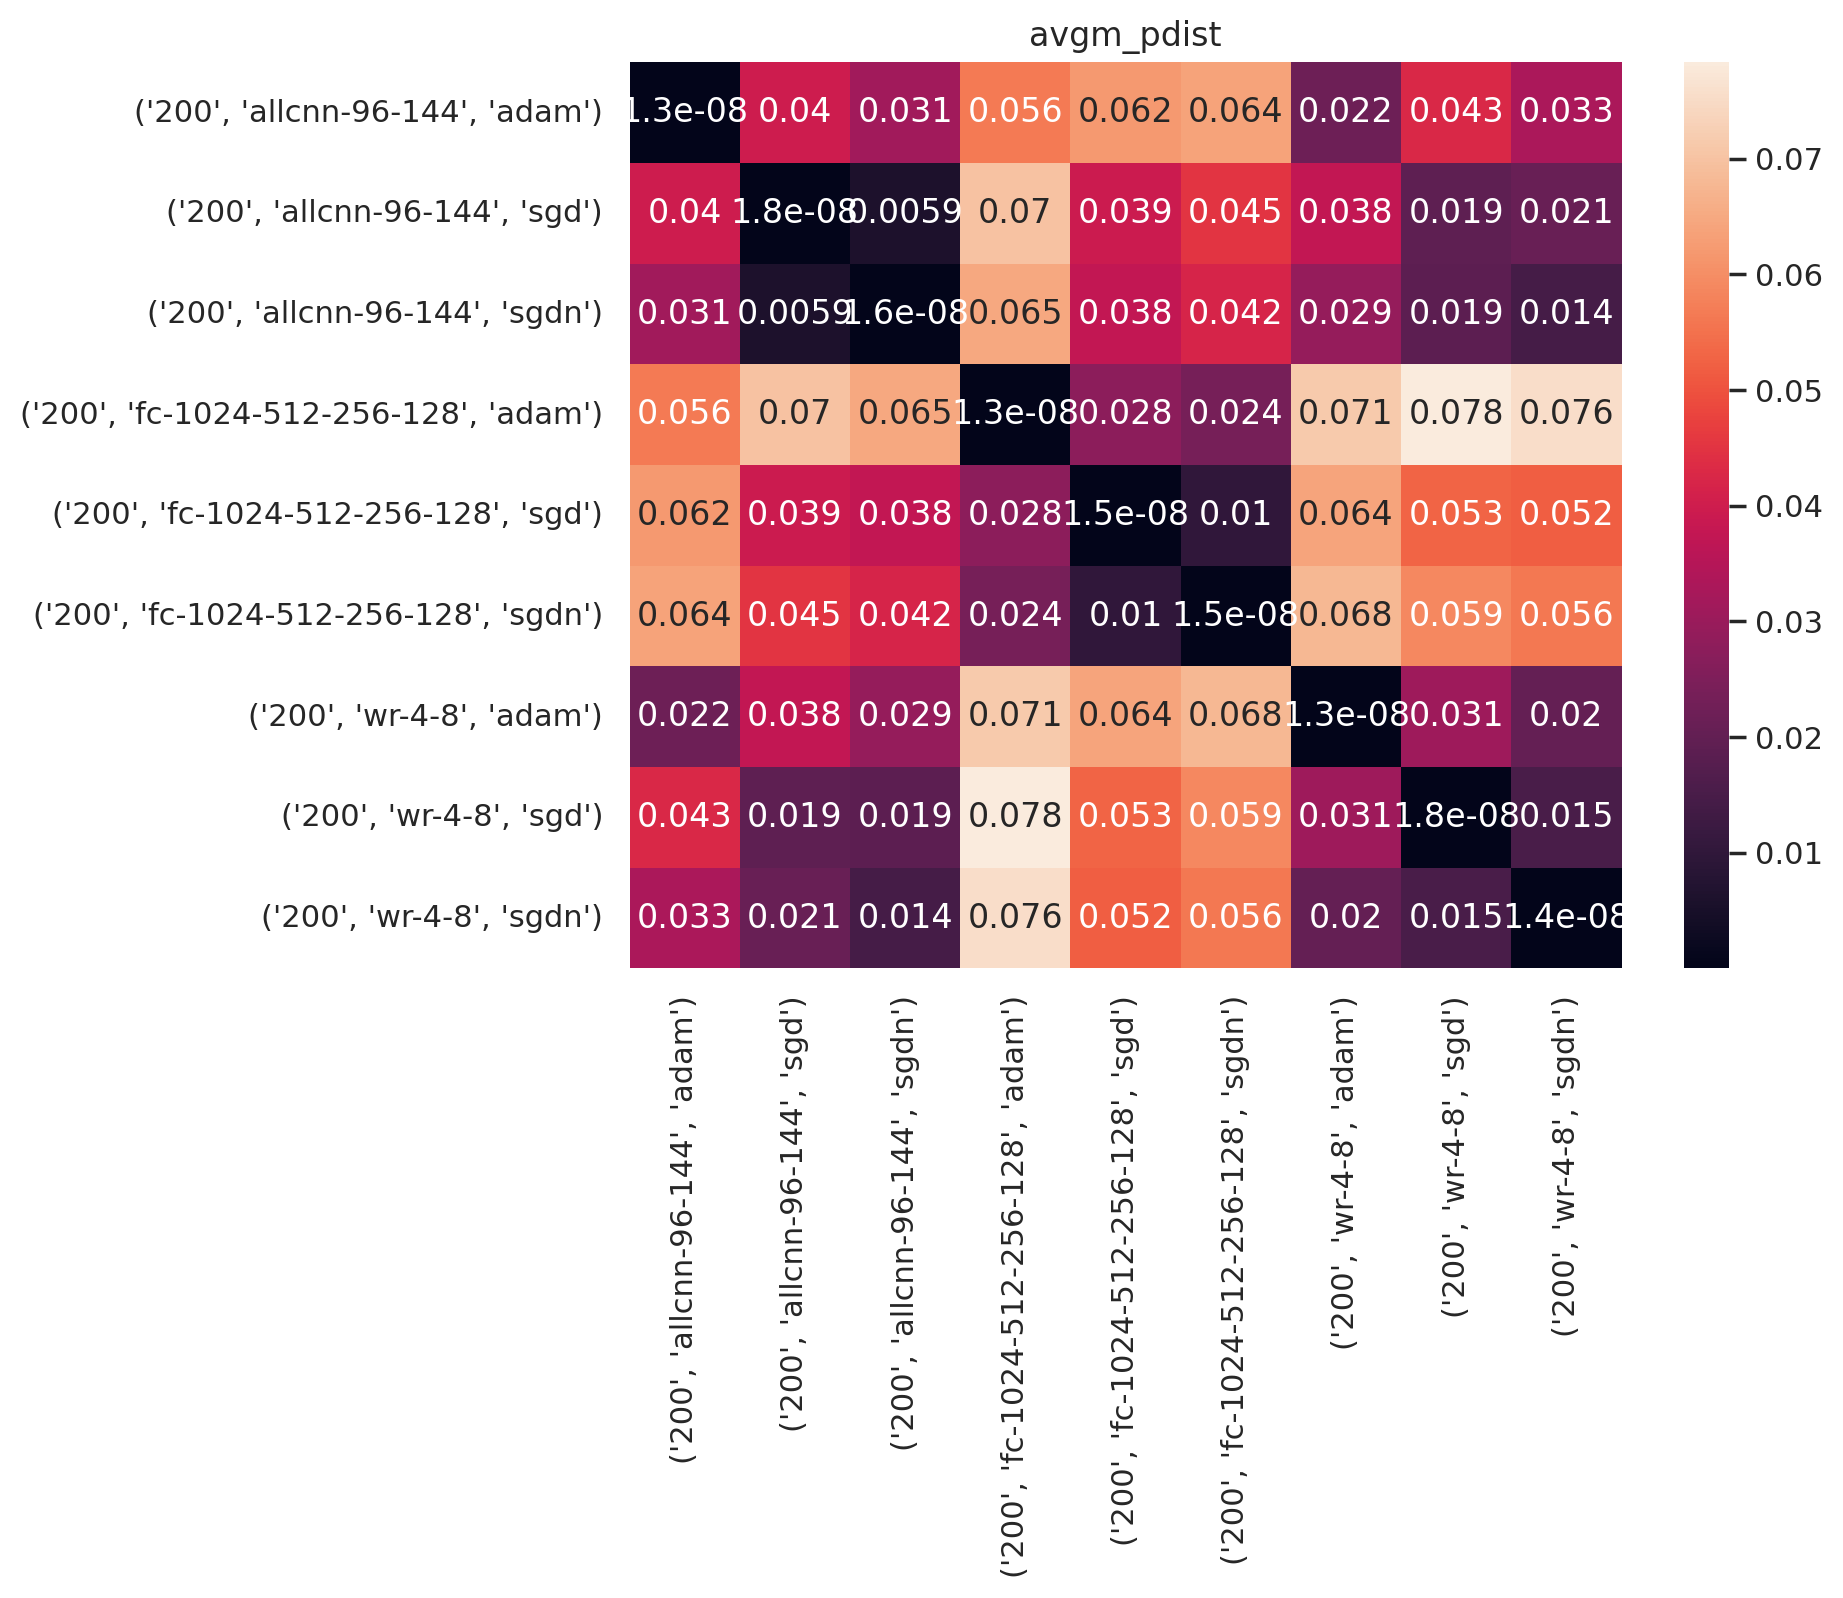

In [18]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length'
dists, symd, configs, groups = th.load(
    os.path.join(loc, f'{fname}.p')).values()
ax, didxs, rows, columns = plot_pairwise_dist(symd, configs, cconds=[
    lambda x: x[-1] == -1], mean=False, sortby=1, xblock_size=1, annot=True, square=True)
ax.set_title(f"avgm_pdist")

Text(0.5, 1.0, 'dist_0.0_mean_length_dist_to_avg')

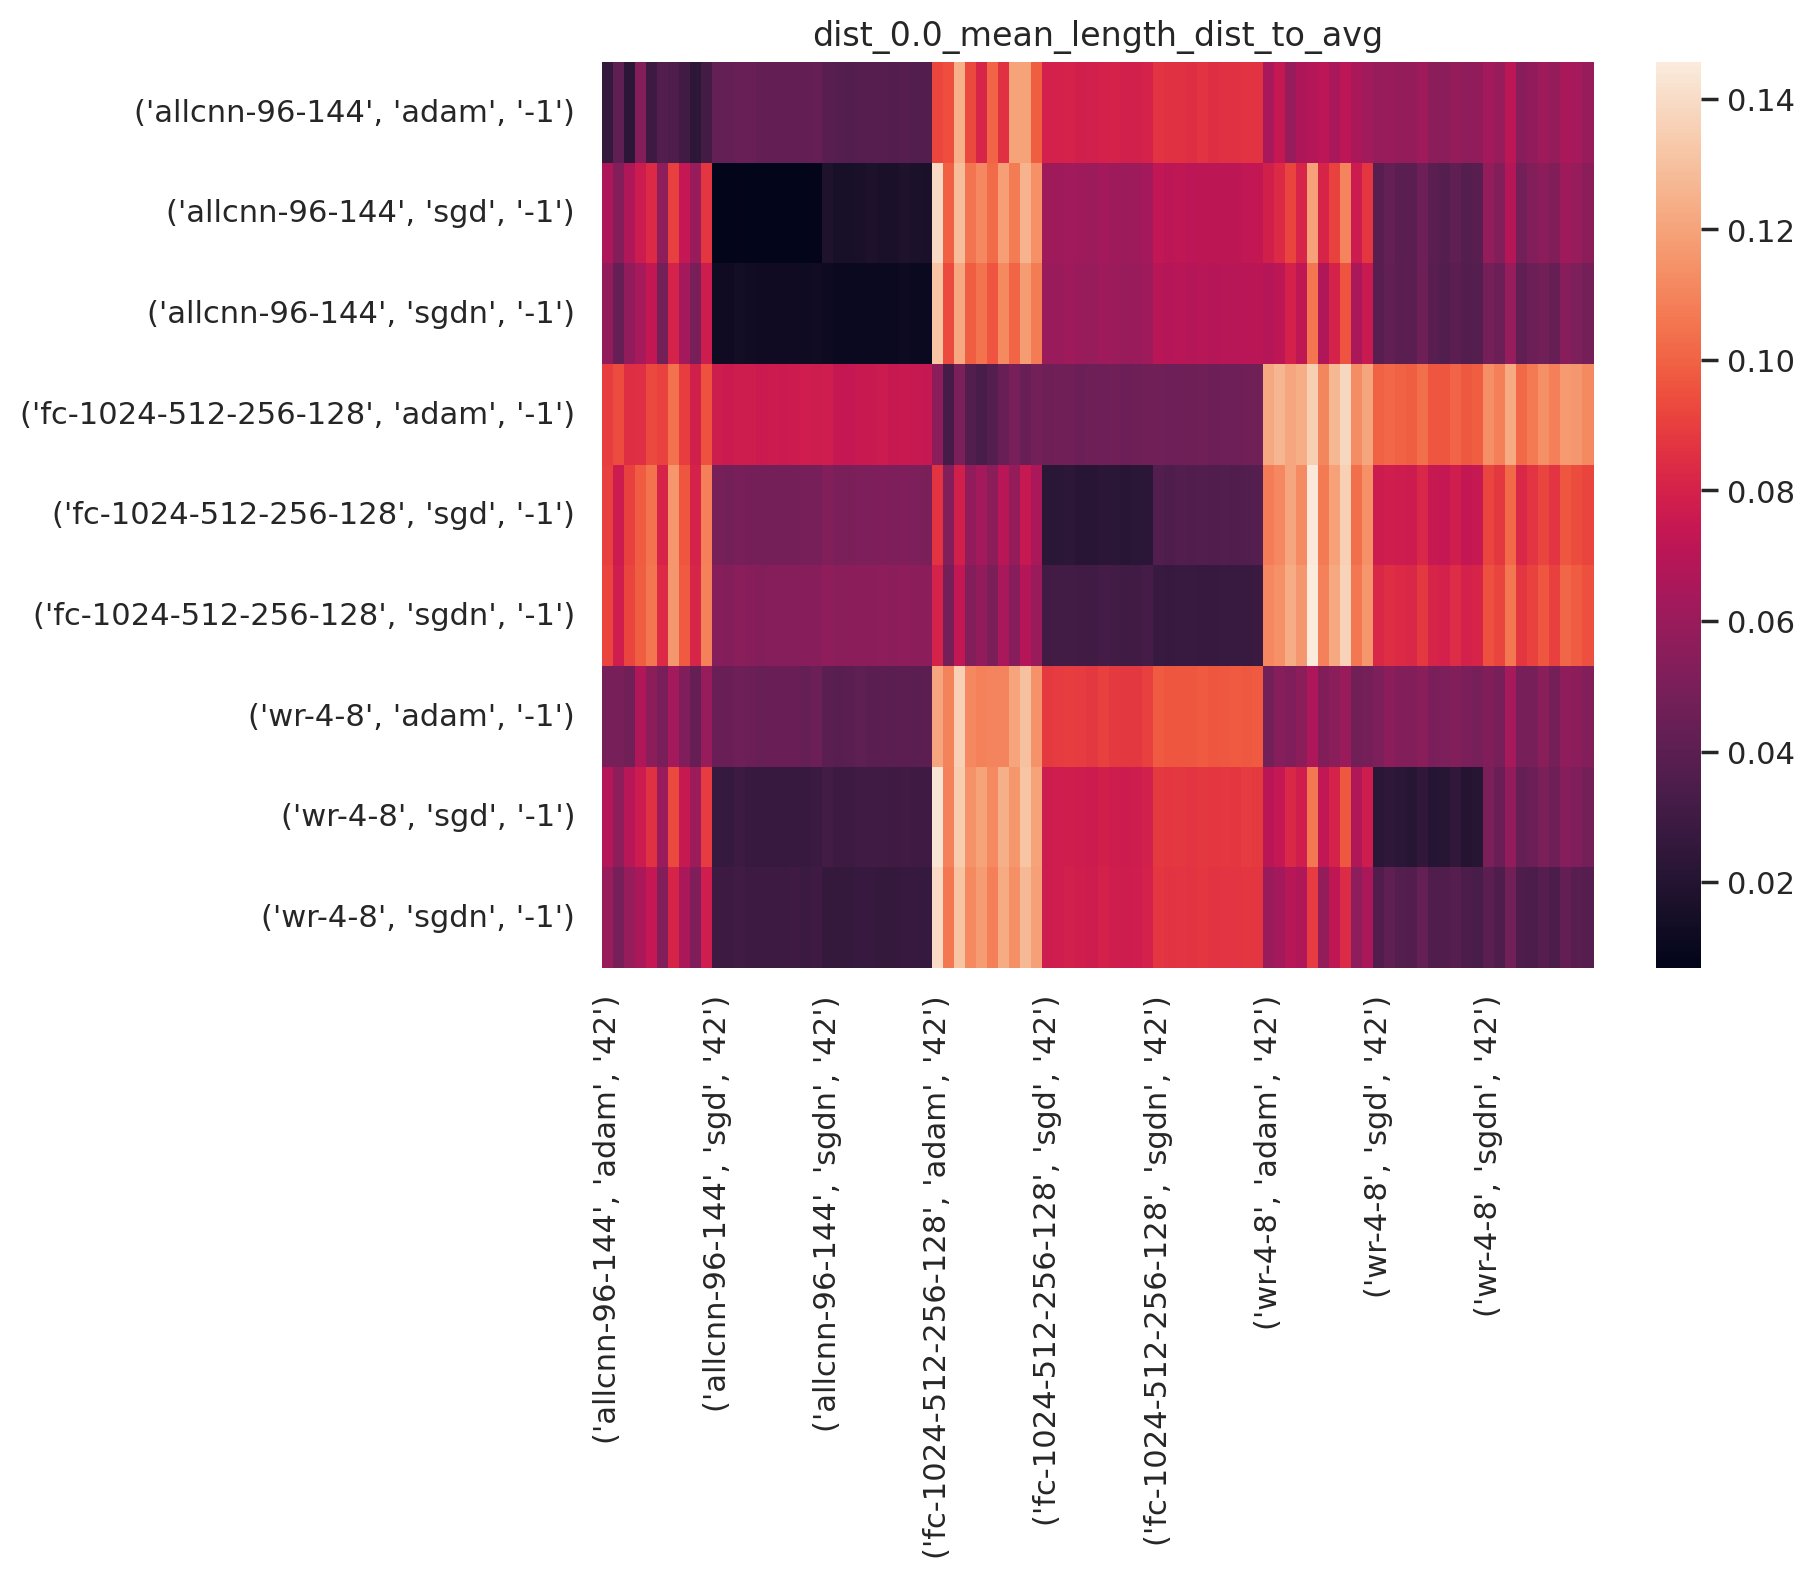

In [19]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length'
dists, symd, configs, groups= th.load(os.path.join(loc, f'{fname}.p')).values()
ax, didxs, rows, columns = plot_pairwise_dist(symd, configs, 
        cconds=[lambda x: x[-1] > 0], 
        rconds=[lambda x: x[-1] == -1], 
        sortby=1, xblock_size=10, yblock_size=1, label_idxs=slice(1, 4), 
        mean=False, annot=False)
davg, _, _ = plot_pairwise_dist(symd, configs, cconds=[
    lambda x: x[-1] == -1], mean=False, sortby=1, xblock_size=1, return_didx=True, square=True)
ax.set_title(f'{fname}_dist_to_avg')


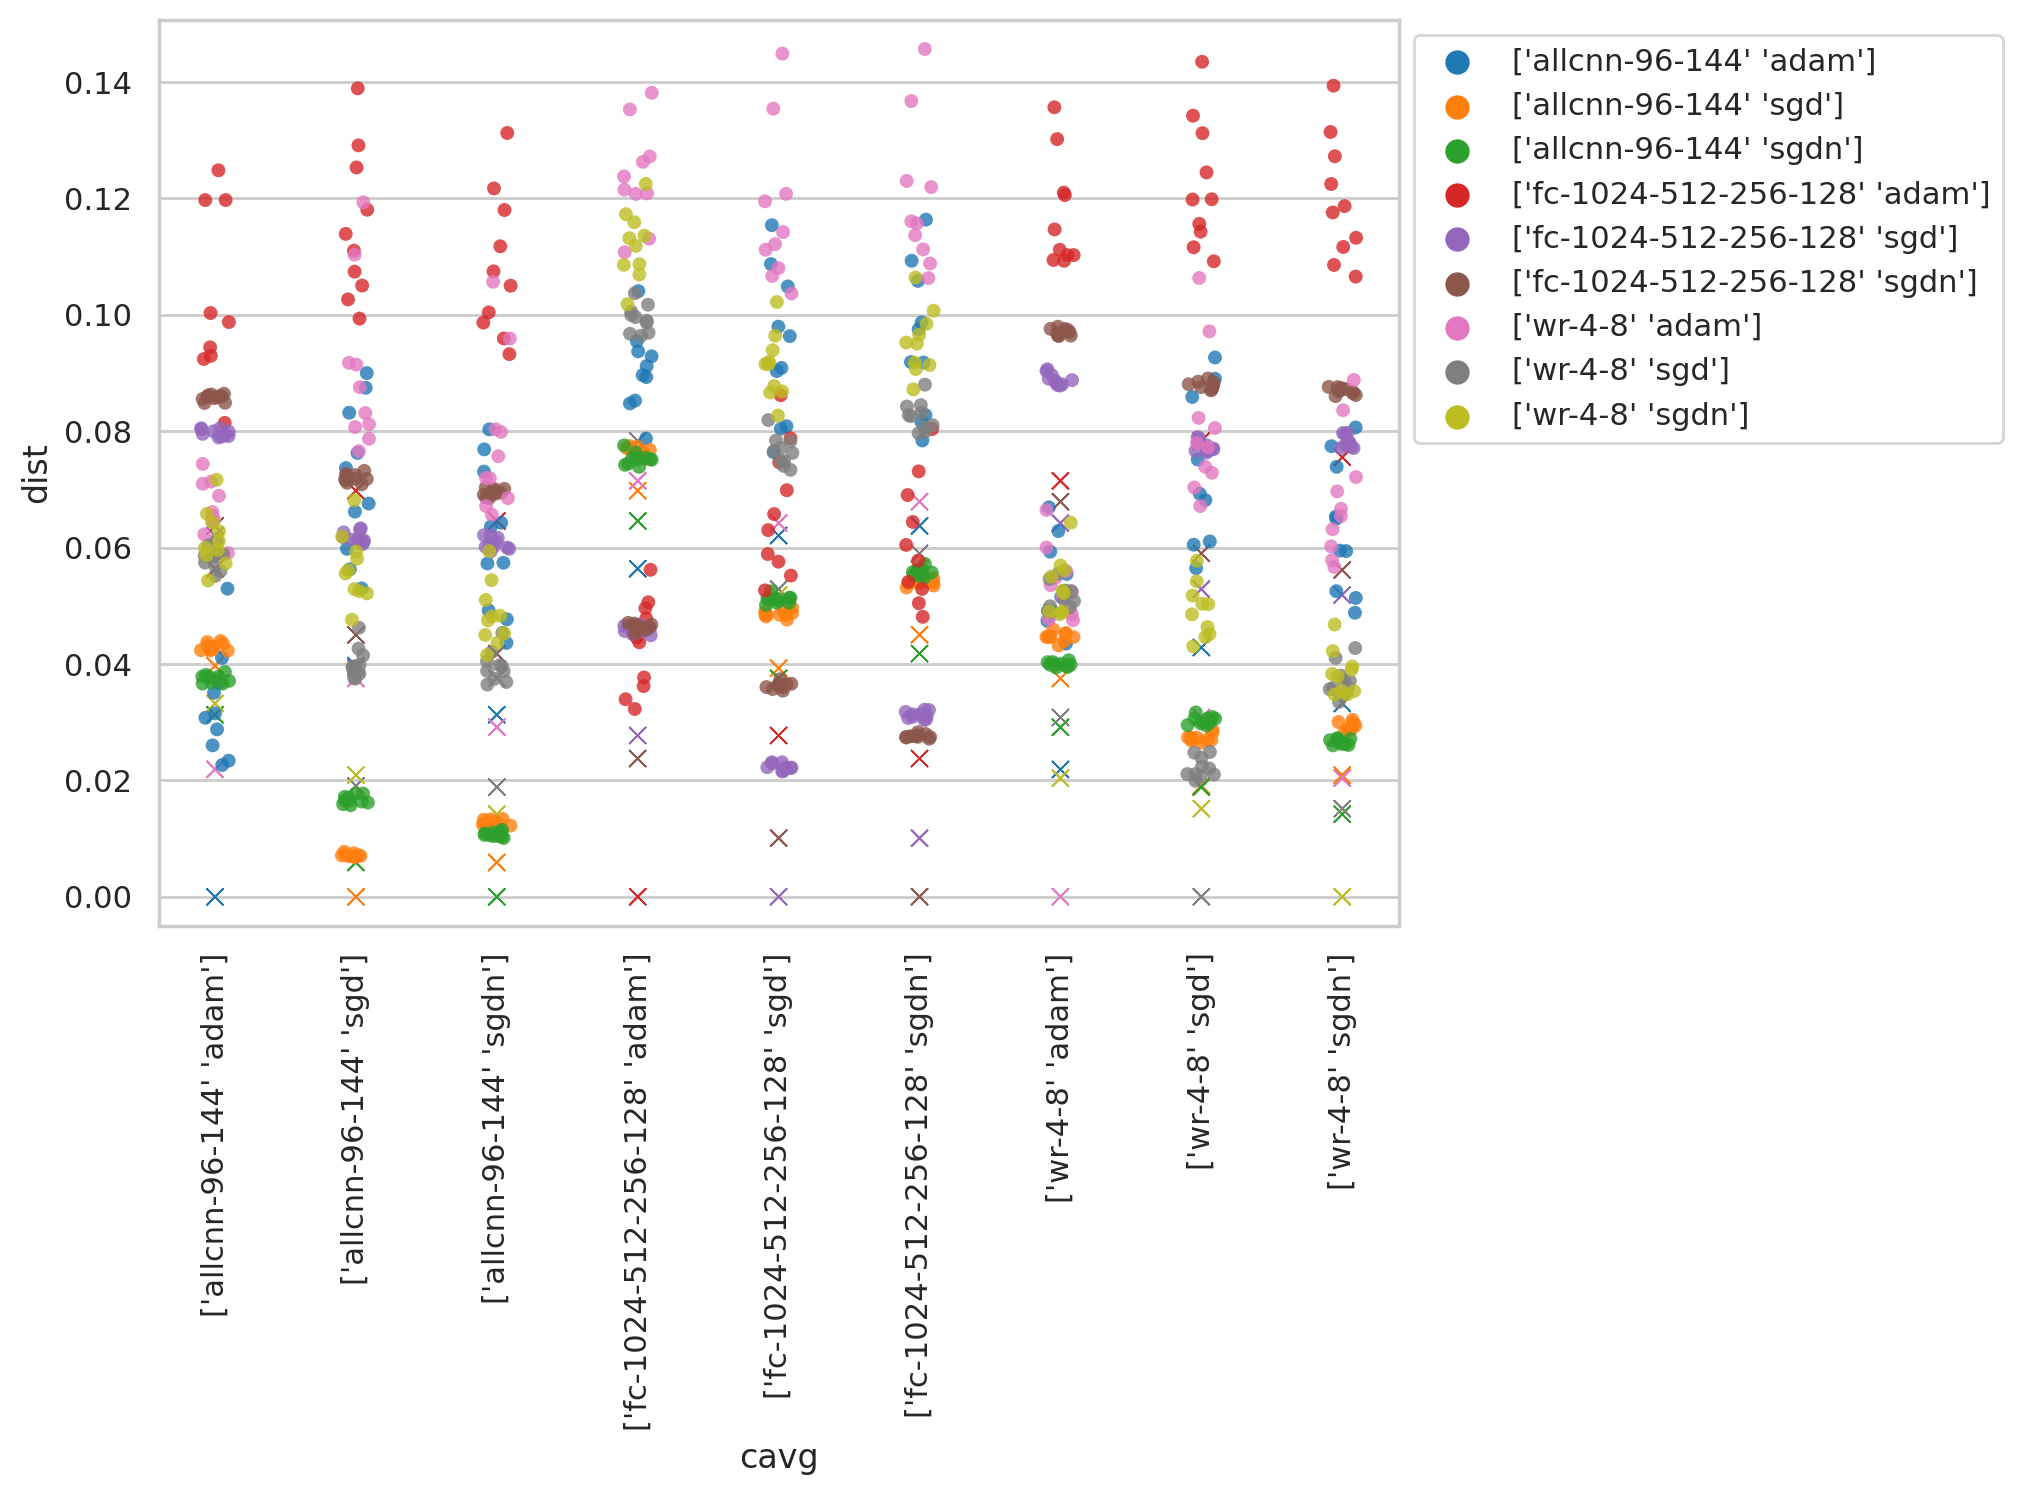

In [31]:
df = []
for i in range(len(didxs)):
    for j in range(len(didxs[i, :])):
        df.append({'cavg': str(rows[i][:-1]), 'cm': str(columns[j][:-1]), 'dist': didxs[i, j], 'davg': davg[i, j//10]})
df = pd.DataFrame(df)
ax=sns.stripplot(data=df, x='cavg', y='dist', hue='cm', alpha=.8)
ax = sns.scatterplot(data=df, x='cavg', y='davg', hue='cm', marker='x', ax=ax, legend=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylim=(-0.005, didxs.max()+0.005))
plt.legend(bbox_to_anchor=(1, 1), loc=2)

Text(0.5, 1.0, 'new_avg_0.0_mean_length_dist_to_avg')

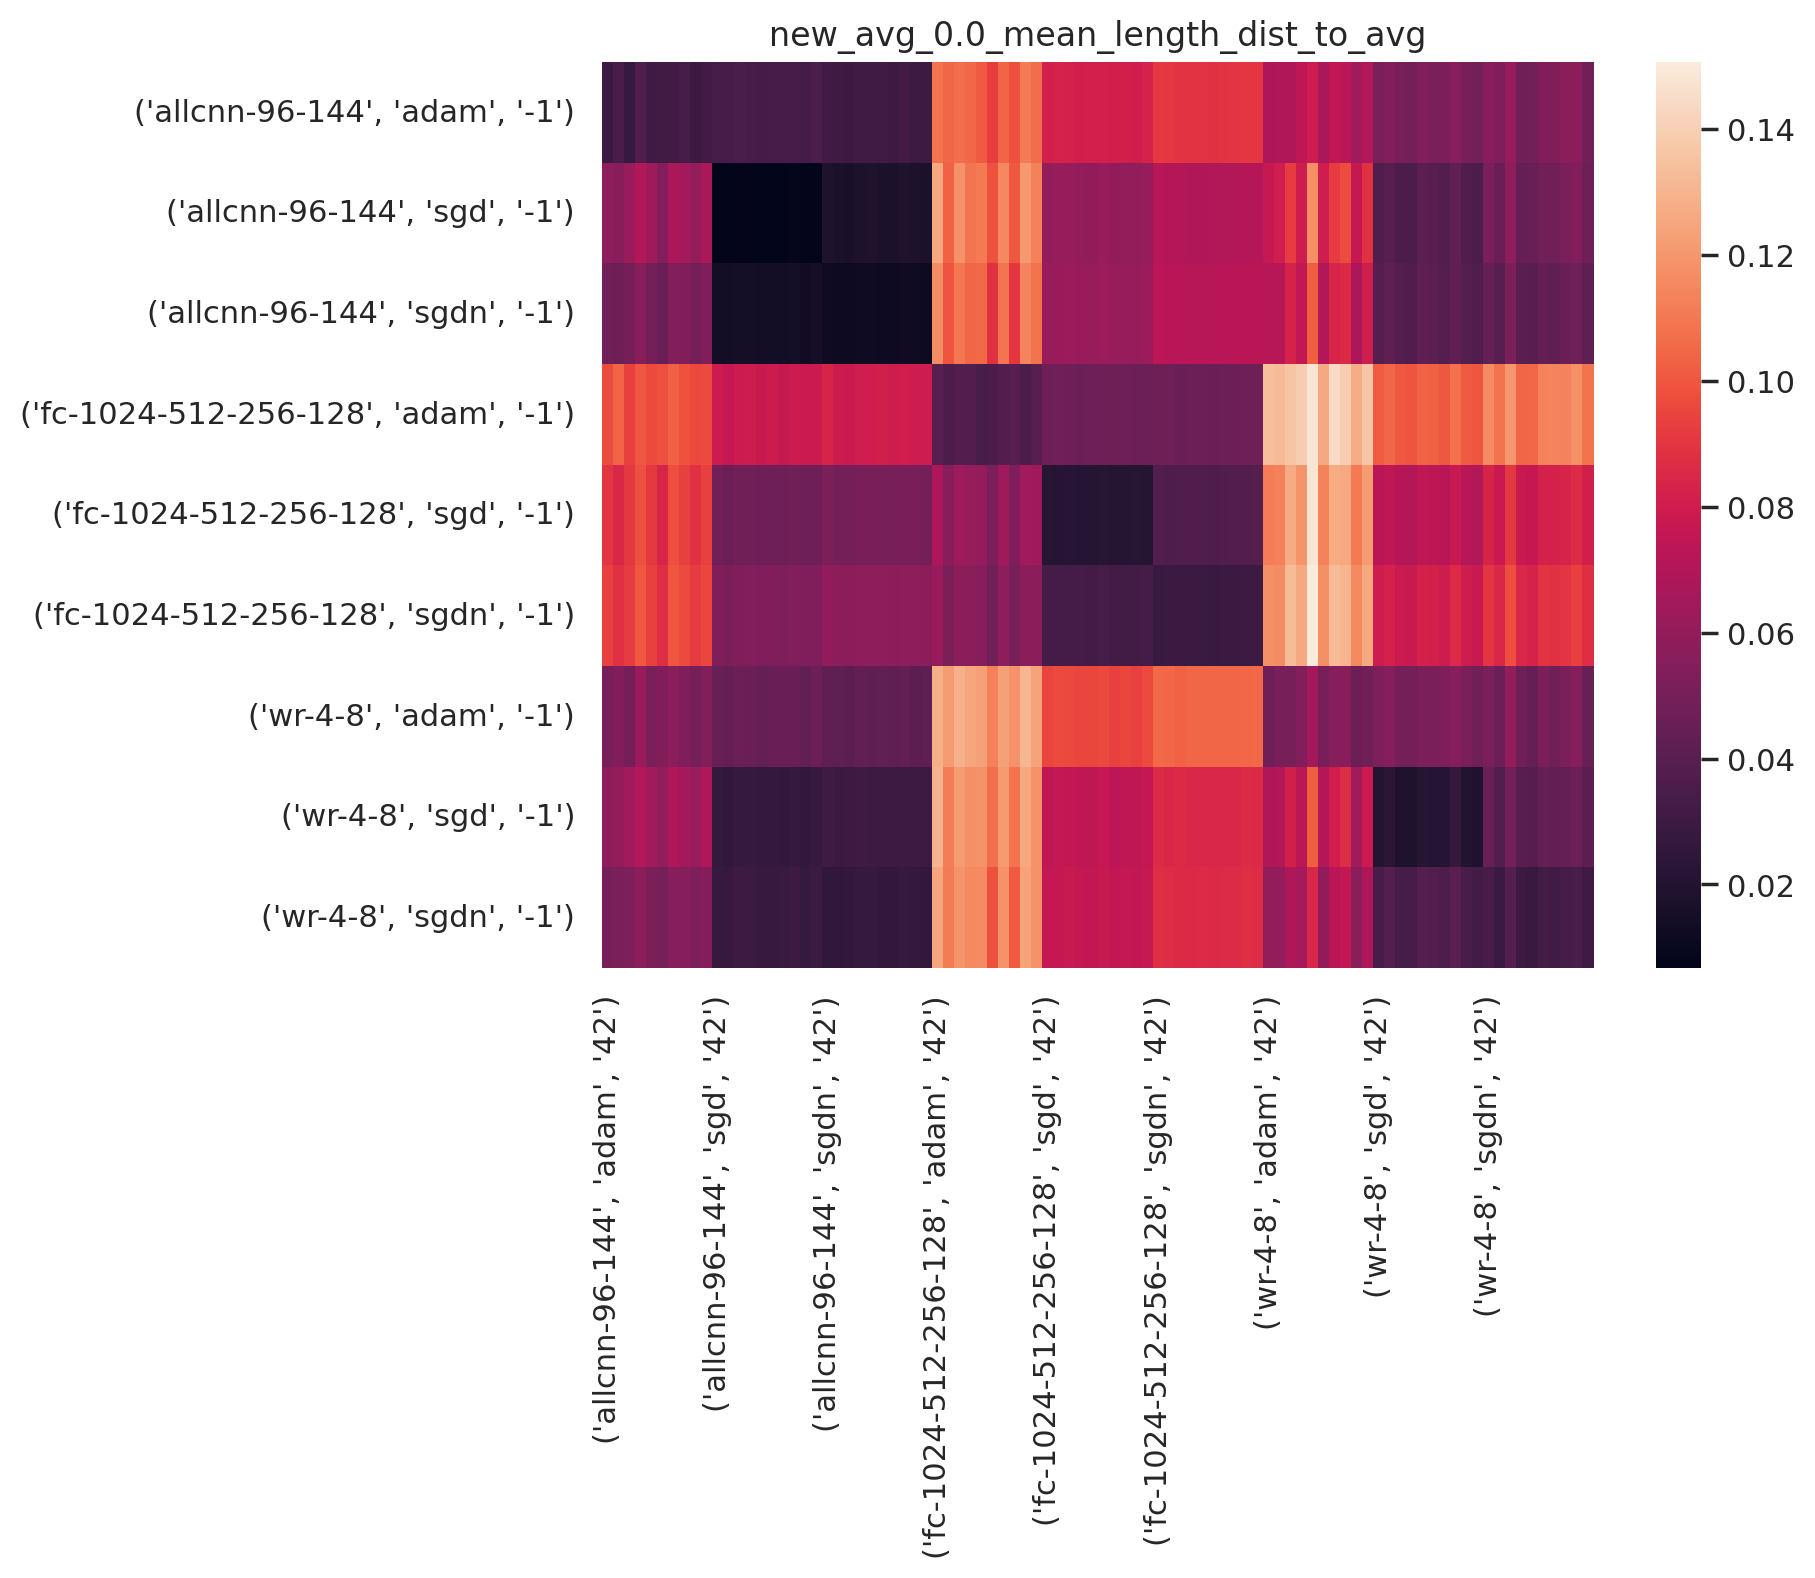

In [22]:
loc = 'results/models/new'
fname = 'new_avg_0.0_mean_length'
dists, symd, configs, groups = th.load(
    os.path.join(loc, f'{fname}.p')).values()
ax, didxs, rows, columns = plot_pairwise_dist(symd, configs,
                                              cconds=[lambda x: x[-1] > 0],
                                              rconds=[lambda x: x[-1] == -1],
                                              sortby=0, xblock_size=10, yblock_size=1, label_idxs=slice(0, 4),
                                              mean=False, annot=False)
davg, _, _ = plot_pairwise_dist(symd, configs, cconds=[
    lambda x: x[-1] == -1], mean=False, sortby=1, xblock_size=1, return_didx=True, square=True)
ax.set_title(f'{fname}_dist_to_avg')


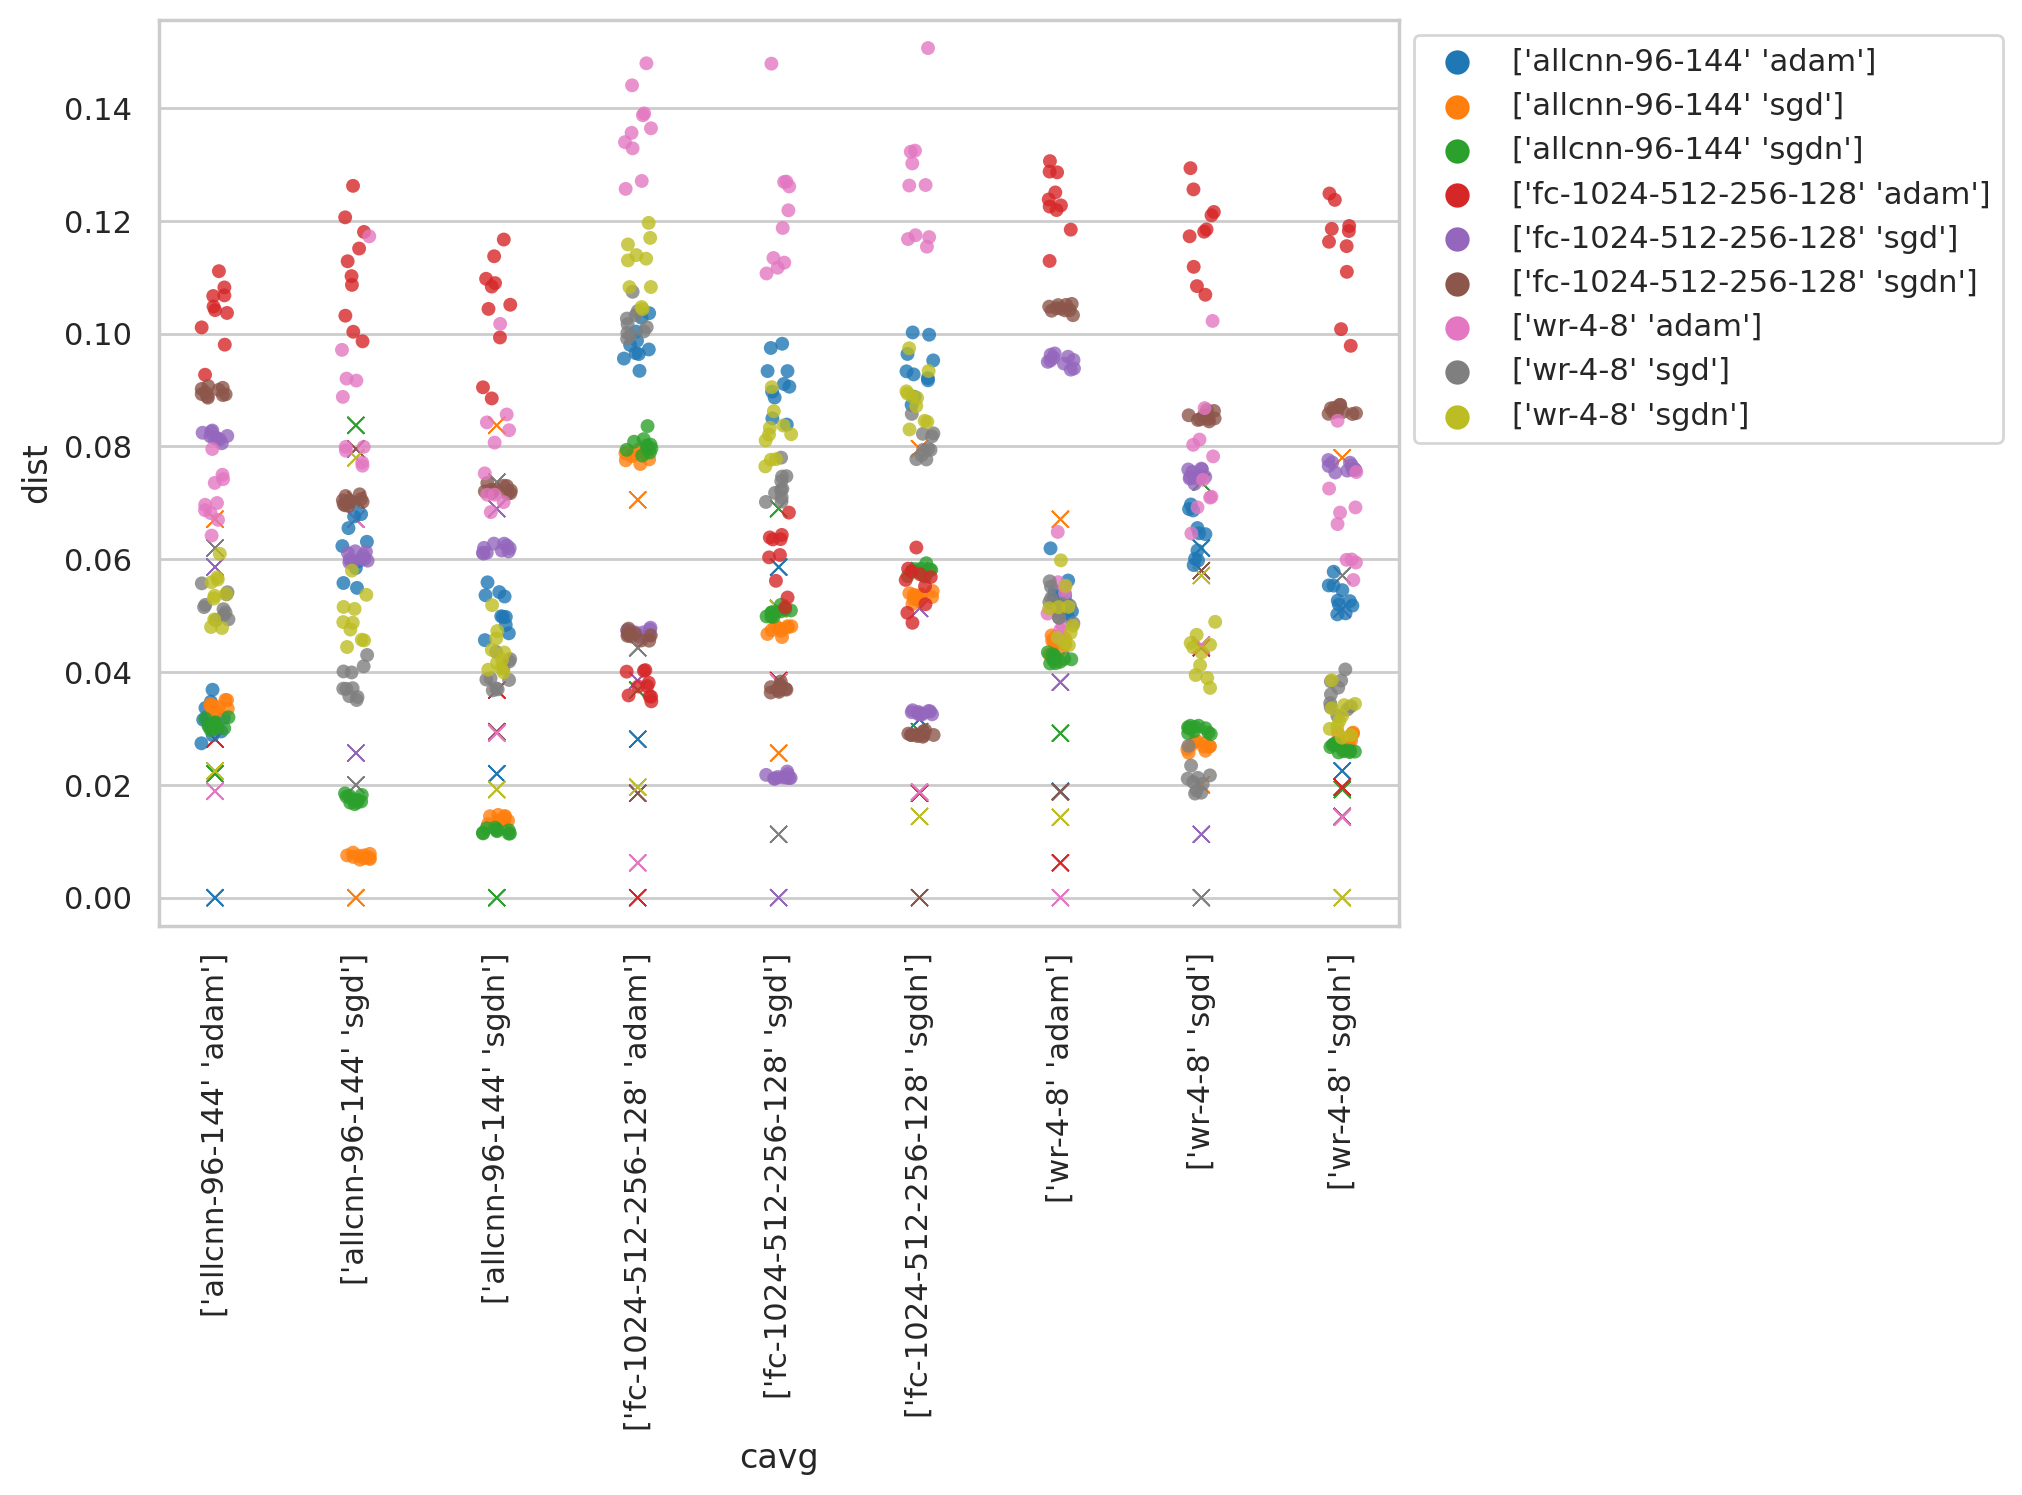

In [23]:
df = []
for i in range(len(didxs)):
    for j in range(len(didxs[i, :])):
        df.append({'cavg': str(rows[i][:-1]), 'cm': str(columns[j][:-1]), 'dist': didxs[i, j], 'davg': davg[i, j//10]})
df = pd.DataFrame(df)
ax=sns.stripplot(data=df, x='cavg', y='dist', hue='cm', alpha=.8)
ax = sns.scatterplot(data=df, x='cavg', y='davg', hue='cm', marker='x', ax=ax, legend=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylim=(-0.005, didxs.max()+0.005))
plt.legend(bbox_to_anchor=(1, 1), loc=2)

Text(0.5, 1.0, 'dist_0.0_mean_length_avgm_pdist')

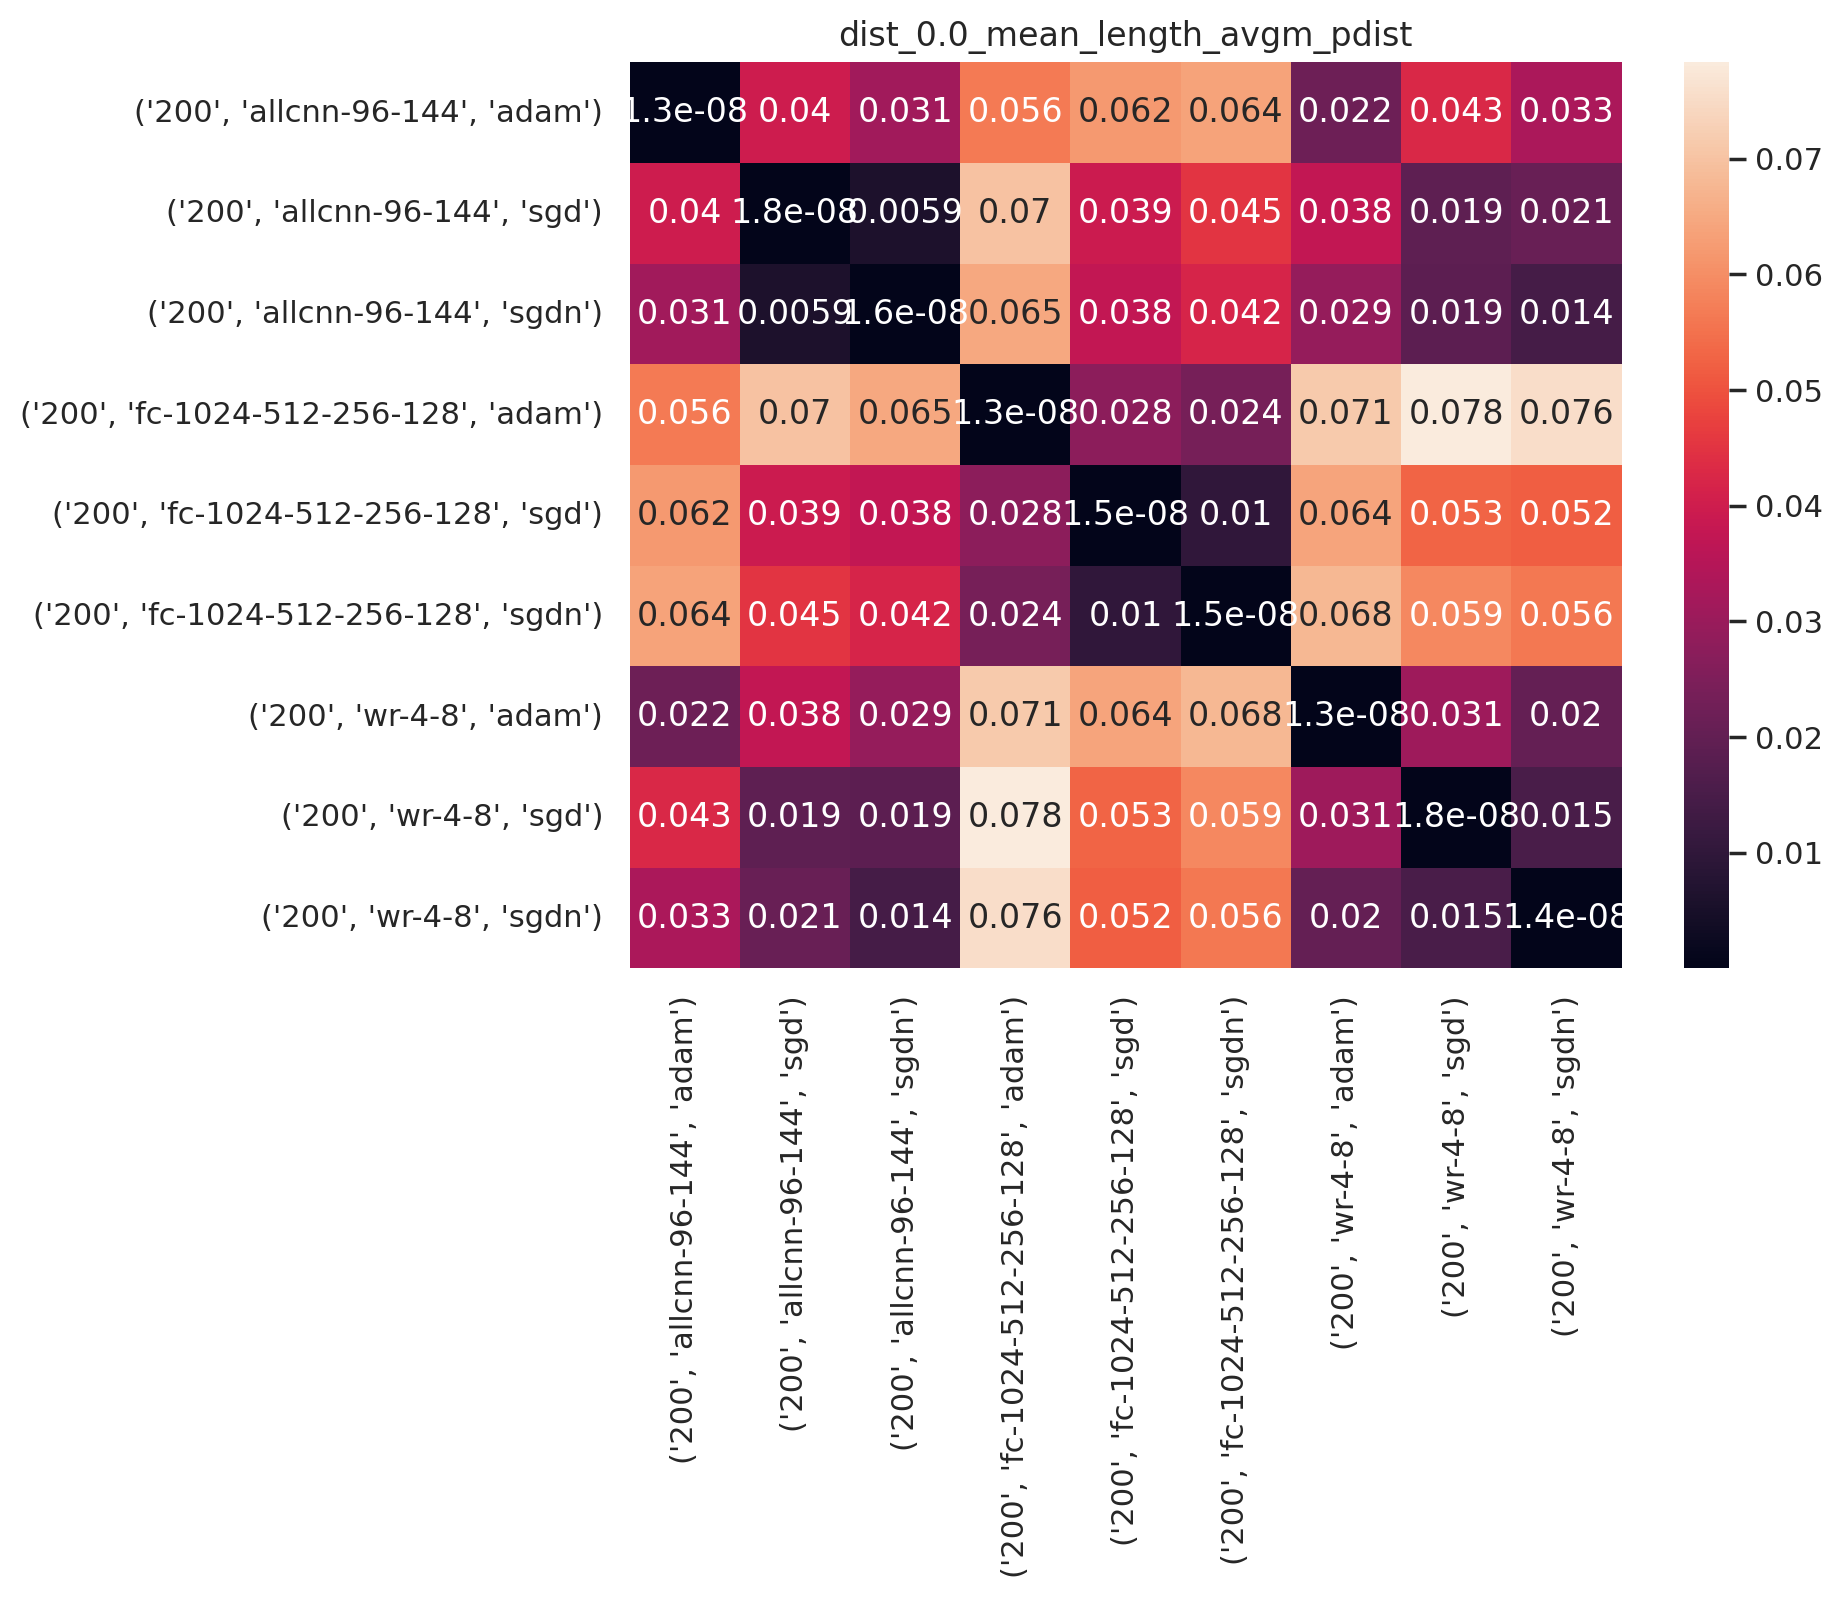

In [41]:
loc = 'results/models/new'
fname = 'dist_0.0_mean_length'
dists, symd, configs, groups= th.load(os.path.join(loc, f'{fname}.p')).values()
ax, didxs, rows, columns=plot_pairwise_dist(symd, configs, 
                                            cconds=[lambda x: x[-1] == -1], mean=False, sortby=1, 
                                            xblock_size=1, annot=True, square=True)
ax.set_title(f"{fname}_avgm_pdist")